# Community Detection Based on Girvan-Newman algorithm

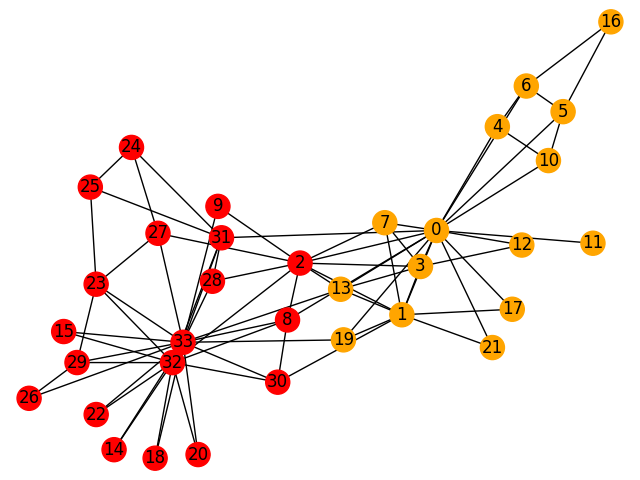

### Girvan-Newman algorithm
- Used to discover communities using divisive hierarchical clustering
- Utilizes recursive splits

Process is as below: <br>
1. Visit each node 
2. From each node, perform BFS (Breadth First Search)
3. Perform credit calculation for each edges 
4. For each edge, accmulate all the credits assigned to it for each node-scenario, and divide the final value by two (since undirected edge are counted twice, from A to B, and B to A)

In [1]:
import findspark
findspark.init()

In [2]:
import time
import sys
from operator import add
import copy
import pandas as pd

In [3]:
from pyspark import SparkContext, SparkConf

In [4]:
conf = SparkConf().setAppName("task2").setMaster("local[*]")
sc = SparkContext(conf=conf)

In [5]:
input_file_path = 'ub_sample_data.csv'

### Initial Data Format

The data is composed of two columns: user id and business id. <br>
This format of the data is not apt for community detection. <br>
Therefore, we will need to reformat.

In [6]:
df = pd.read_csv('ub_sample_data.csv')
df.head()

,user_id,business_id
0,39FT2Ui8KUXwmUt6hnwy-g,RJSFI7mxGnkIIKiJCufLkg
1,39FT2Ui8KUXwmUt6hnwy-g,fThrN4tfupIGetkrz18JOg
2,39FT2Ui8KUXwmUt6hnwy-g,mvLdgkwBzqllHWHwS-ZZgQ
3,39FT2Ui8KUXwmUt6hnwy-g,uW6UHfONAmm8QttPkbMewQ
4,39FT2Ui8KUXwmUt6hnwy-g,T70pMoTP008qYLsIvFCXdQ


### Initial Data Input

##### .filter(lambda x: x != 'user_id,business_id') 
Removes the header <br>

##### .map(lambda x: x.split(",")) 
Turns each row into a list with two elements: user id and business id.

In [7]:
data = sc.textFile(input_file_path).filter(lambda x: x != 'user_id,business_id').map(lambda x: x.split(",")).persist()

In [8]:
data.take(5)

[['39FT2Ui8KUXwmUt6hnwy-g', 'RJSFI7mxGnkIIKiJCufLkg'],
 ['39FT2Ui8KUXwmUt6hnwy-g', 'fThrN4tfupIGetkrz18JOg'],
 ['39FT2Ui8KUXwmUt6hnwy-g', 'mvLdgkwBzqllHWHwS-ZZgQ'],
 ['39FT2Ui8KUXwmUt6hnwy-g', 'uW6UHfONAmm8QttPkbMewQ'],
 ['39FT2Ui8KUXwmUt6hnwy-g', 'T70pMoTP008qYLsIvFCXdQ']]

### Data Reformat (i)

We will assume that when there are more than 7 common businesses two users have in common, there will be an edge between those two verticies.

In [9]:
threshold = 7

In [10]:
initial_vertex_list = data.map(lambda x: x[0]).distinct().collect()
initial_vertex_list[0:10] # sample look

['39FT2Ui8KUXwmUt6hnwy-g',
 '0FVcoJko1kfZCrJRfssfIA',
 '_6Zg4ukwS0kst9UtkfVw3w',
 'JM0GL6Dx4EuZ1mprLk5Gyg',
 'LcCRMIDz1JgshpPGYfLDcA',
 'bSUS0YcvS7UelmHvCzNWBA',
 'lJFBgSAccsMGwIjfD7LMeQ',
 '23o7tyUGlC6FCDVcyqLeFA',
 'CLbpPUqP6XpeAfoqScGaJQ',
 'CMu9FmdK8xpiawJowJuGQg']

In [11]:
u_to_b = data.groupByKey().mapValues(set).collectAsMap()
u_to_b[initial_vertex_list[0]]

{'-JFVxwdVQfX207554dx1nw',
 '-YGQwikbX2fXUIjyegR7pw',
 '-kG0N8sBhBotMbu0KVSPaw',
 '-kyvpeXIuQDKIYDkAK7ryw',
 '-zbcosKSMGDhaZYN-CrcVA',
 '02Ycww2etUAxorZb5gIM8Q',
 '0KjY3gmtqQjc4sK-uG-6fQ',
 '0jHZk9RrKh0uRhTRW1XIqQ',
 '0ptR21GHRuQ1MFtxGNcxzw',
 '0sPOBQHlVvuhO1h-1p1ccQ',
 '1NZonnS3SpogXaZJigVgqA',
 '1jpYP-JNOEYCMIzP4OlGuQ',
 '20ib4z2Yo2wlfARFMcFwSQ',
 '2g_auUWw7c3c2CUTgVqI8Q',
 '2hgN9BGgenv8mZ0A8ybhGQ',
 '338D7EQfInzHV8Ve1b0-eQ',
 '364hhL5st0LV16UcBHRJ3A',
 '3OKwP3ylofhDJDtWJQu5GQ',
 '3ViGD_AF1AUmxF4zeHB_kQ',
 '3uOxuJUnx72b86-3NKhX0A',
 '3vxIqhm2jCVjkUWtmDvTsw',
 '44FSoN5Wj2B9vZTTYHlQZQ',
 '476CROJauLg6CtssqHRxmA',
 '47guZqFjz2V5TJcdtvooJw',
 '4BBda3yy_8GXGmYLcgggHw',
 '4GJc_Ls4f2uVptSfFQTL5g',
 '4JNXUYY8wbaaDmk3BPzlWw',
 '50tjBMTlIbFBxjTRXAVZHQ',
 '5CJL_2-XwCGBmOav4mFdYg',
 '5KcrEqWVHrkBH9W8H6cC9w',
 '5mu4SWwVTgNUXw0lWLaoZw',
 '5xYk23lz0ktdMvzHtohymQ',
 '66VUcHJlDmRANxSb9skvMA',
 '67Pa_CtXthgJzXfY8JzLDQ',
 '68jn0s0snbO5dhasLaVvDw',
 '6Eks3cn0UGUqQjXxXpSPDg',
 '6OkjUz-I552moryf3qN1Gg',
 

- For each user, compile a list/set of businesses a user is interested in <br>
- Format is: user_id: {busines_id_1, business_id_2,....}

### Data Reformat (ii)

Iteratively, check whether there exists an edge between all pair combination of vertices. <br>
- Can reduce the duration in half by checking half of the matrix (triangle)
- Must record edges from both side (A,B), (B,A) since our graph will be undirected and unweighted
- Must eliminate vertices that don't have edges

In [12]:
def find_edge(vertex_list,threshold):
    edge_list = []
    final_vertex_list = set()
    length = len(vertex_list)
    for i in range(0,length-1,1):
        for j in range(i+1,length,1):
            if len(u_to_b[vertex_list[i]].intersection(u_to_b[vertex_list[j]])) >= threshold:
                edge_list.append([vertex_list[i],vertex_list[j]])
                edge_list.append([vertex_list[j],vertex_list[i]])
                final_vertex_list.add(vertex_list[i])
                final_vertex_list.add(vertex_list[j])
                
    return edge_list, list(final_vertex_list)

In [13]:
edge_list, vertex_list = find_edge(initial_vertex_list,threshold)

In [14]:
edge_list[0:5]

[['39FT2Ui8KUXwmUt6hnwy-g', '0FVcoJko1kfZCrJRfssfIA'],
 ['0FVcoJko1kfZCrJRfssfIA', '39FT2Ui8KUXwmUt6hnwy-g'],
 ['39FT2Ui8KUXwmUt6hnwy-g', 'JM0GL6Dx4EuZ1mprLk5Gyg'],
 ['JM0GL6Dx4EuZ1mprLk5Gyg', '39FT2Ui8KUXwmUt6hnwy-g'],
 ['39FT2Ui8KUXwmUt6hnwy-g', 'bSUS0YcvS7UelmHvCzNWBA']]

In [15]:
vertex_list[0:5]

['ay4M5J28kBUf0odOQct0BA',
 'DjcRgZ0cJbf6-W2TxvFlBA',
 '39FT2Ui8KUXwmUt6hnwy-g',
 'nOTl4aPC4tKHK35T3bNauQ',
 'ZEq0WtRJD9Bl_vYgCsbfOg']

### Data Reformat (iii)
Created a dictionary with the key being an vertex and value being vertices the vertex has an edge connected to

In [16]:
edge_dict = sc.parallelize(edge_list).groupByKey().mapValues(list).collectAsMap()

In [17]:
edge_dict['39FT2Ui8KUXwmUt6hnwy-g']

['0FVcoJko1kfZCrJRfssfIA',
 'JM0GL6Dx4EuZ1mprLk5Gyg',
 'bSUS0YcvS7UelmHvCzNWBA',
 'DKolrsBSwMTpTJL22dqJRQ',
 'sdLns7062kz3Ur_b8wgeYw',
 '_VTEyUzzH92X3w-IpGaXVA',
 'qtOCfMTrozmUSHWIcohc6Q',
 'zBi_JWB5uUdVuz3JLoAxGQ',
 'KLB3wIYUwKDPMbijIE92vg',
 '1KQi8Ymatd4ySAd4fhSfaw',
 '_Pn-EmWO-pFPFg81ZIEiDw',
 'dTeSvET2SR5LDF_J07wJAQ',
 'ay4M5J28kBUf0odOQct0BA',
 'dzJDCQ5vubQBJTfYTEmcbg',
 'mu4XvWvJOb3XpG1C_CHCWA',
 'OoyQYSeYNyRVOmdO3tsxYA',
 'PE8s8ACYABRNANI-T_WmzA',
 '79yaBDbLASfIdB-C2c8DzA',
 'Uo5dPwoDpYBzOnmUnjxJ6A',
 'R4l3ONHzGBakKKNo4TN9iQ',
 'bHufZ2OTlC-OUxBDRXxViw',
 'ChshgCKJTdIDg17JKtFuJw',
 'B0ENvYKQdNNr1Izd2r-BAA']

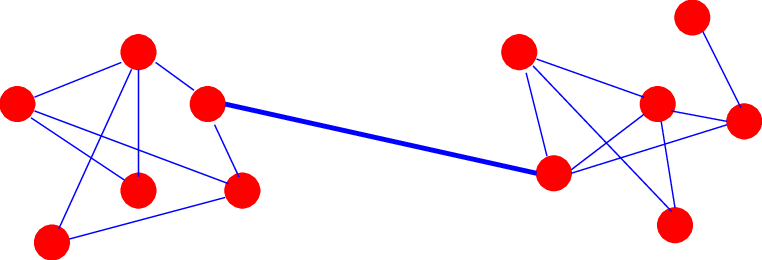

### Betweenness
Edge betweenness: Number of shortest paths passing over the edge <br>
- High value of betweenness indiciates that the edge is most likely not WITHIN the community but rather CONNECTING communities (bridge)
<br>

Once we have established betweeness value for all edges, we will begin to cut the graphs into communities by removing the edge with the highest betweeness score. We will continuously perform this procedure, and we will determine when to stop by using modularity as our metrics. 
- Modularity: A measure of how well a network is partitioned: Sum of, for each group, (# of edges - expected # of edges)

#### bfs(vertex, edge_dict):

The function performs breadth-first search. 
The mechanism is: 
- Select a vertex to begin.
- Search through all the edges that are connected to initial edge. (1st layer)
- Recursively, continue to find edges that are connected to the previous layer until we exhaust all edges.

In [18]:
def bfs(vertex,edge_dict):
    leveled_vertices = []
    previous = set()
    current_lvl = []
    next_lvl = []
    current_lvl.append(vertex)
    previous.add(vertex)
    temp = set()
    
    shortest_path = {}
    shortest_path[vertex] = [1, None]
    
    while current_lvl:
        s = current_lvl.pop(0)
        temp.add(s)
        for i in edge_dict[s]:
            if i not in previous:
                previous.add(i)
                next_lvl.append(i)
        
        if not current_lvl:
            leveled_vertices.append(list(temp))
            current_lvl = next_lvl.copy()
            for j in next_lvl:
                parent = list(temp.intersection(edge_dict[j]))
                weight_sum = 0
                for k in parent:
                    weight_sum += shortest_path[k][0]
                shortest_path[j] = [weight_sum, parent]
            
            temp = set()
            next_lvl.clear()
            
    edge_credit = weight(vertex,leveled_vertices,shortest_path)    
    return edge_credit

#### weight(vertex, lvl_list, path):
The function, once we have a completed graph in BFS layout, calculates the betweeness value and credit value for each edges.

In [19]:
def weight(vertex, lvl_list, path):
    node_credit = {}
    edge_credit = {}
    for i in vertex_list:
        if i != vertex:
            node_credit[i] = 1
        else:
            node_credit[i] = 0
    
    reverse_level = list(reversed(lvl_list))
    for i in range(0,len(lvl_list)-1,1):
        for j in reverse_level[i]:
            num_parent = path[j][0]
            parent = path[j][1]
            for k in parent:
                temp = [k,j]
                temp_tuple = tuple(temp)
                edge_credit[temp_tuple] = float(node_credit[j] * path[k][0] / num_parent)
                node_credit[k] += edge_credit[temp_tuple]
    
    edge_credit = list(edge_credit.items())
    for i in range(0,len(edge_credit),1):
        edge_credit[i] = list(edge_credit[i])
    
    return edge_credit

In [20]:
btw = []
for i in vertex_list:
    for j in bfs(i,edge_dict):
        btw.append([tuple(sorted(j[0])),j[1]])

In [21]:
betweenness = sc.parallelize(btw).groupByKey().mapValues(lambda x: round(float(sum(x)/2),5)).sortBy(lambda x: [-x[1],x[0]]).collect()

In [24]:
betweenness[0:5]

[(('cyuDrrG5eEK-TZI867MUPA', 'l-1cva9rA8_ugLrtSdKAqA'), 4234.0),
 (('1st2ltGKJ00ZcRsev-Ieew', 'DKolrsBSwMTpTJL22dqJRQ'), 3986.4873),
 (('1st2ltGKJ00ZcRsev-Ieew', 'HLY9oDcVBH9D25lU4X_V5Q'), 3857.0),
 (('1st2ltGKJ00ZcRsev-Ieew', 'Hv_q_ZnSIoZwdcoH0CyV2Q'), 3724.0),
 (('1st2ltGKJ00ZcRsev-Ieew', 'JM0GL6Dx4EuZ1mprLk5Gyg'), 3669.5127)]

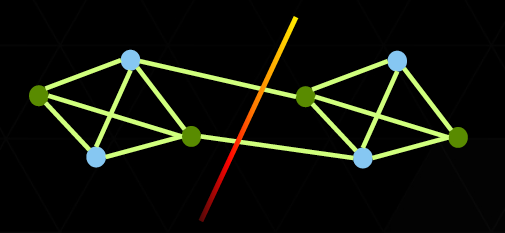

Now, we have all the betweeness value calculated. <br>
We will now use these values to determine which edges need to get cut first. <br>
After each cut, we will calculate our metric (Modularity) and determine whether the graph has been partitioned well. <br>
Once we have established the best metric, we will stop the cutting.

In [25]:
def adjacency(vertex_list):
    edge_set = set()
    edge_set_dict = {}
    for i in vertex_list:
        for j in vertex_list:
            if i != j:
                temp = [i,j]
                temp.sort()
                temp_tuple = tuple(temp)
                edge_set.add(temp_tuple)
                if temp[1] in edge_dict[temp[0]]:
                    edge_set_dict[temp_tuple] = 1
                else:
                    edge_set_dict[temp_tuple] = 0
                        
    final_dict = {}
    for i in edge_set:
        final_dict[i] = edge_set_dict[i]

    return final_dict

In [26]:
def unravel(dictionary):
    final_dict = {}
    for i in dictionary.keys():
        final_dict[i] = len(dictionary[i])
    
    return final_dict

In [27]:
def check_community(edge_dict, vertex_list):
    community_list = []
    previous = set()
    for i in vertex_list:
        temp = set()
        queue = []
        if i not in previous:
            queue.append(i)
            temp.add(i)
            while queue:
                s = queue.pop(0)
                previous.add(s)
                for j in edge_dict[s]:
                    if j not in previous:
                        queue.append(j)
                        temp.add(j)
        
        if temp:
            community_list.append(temp)

    return community_list

In [28]:
def calculate_modularity(community,m,A,K):
    mod_sum = 0
    for i in community:
        previous = set()
        for j in i:
            for k in i:
                temp = [j,k]
                temp.sort()
                temp_tuple = tuple(temp)
                if j != k and temp_tuple not in previous:
                    previous.add(temp_tuple)
                    kikj = K[j] * K[k]
                    mod_sum += (A[temp_tuple] - kikj/2/m)
                
    return mod_sum / m / 2

In [29]:
def edge_to_remove(between):
    remove_list = []
    remove_index = [0]
    first_value = between[0][1]
    go = True
    while go:
        for i in range(1,len(between),1):
            if between[i][1] == first_value:
                remove_index.append(i)
            else:
                go = False
    for i in remove_index:
        remove_list.append(between[i][0])
    
    return remove_list

In [30]:
def update(remove_edge,edge_dict,adj,k):
    for i in remove_edge:
        edge_dict[i[0]].remove(i[1])
        edge_dict[i[1]].remove(i[0])
        adj[i] = 0
        k[i[0]] = k[i[0]] - 1
        k[i[1]] = k[i[1]] - 1
    
    return edge_dict, adj, k

In [31]:
def community_detection(between,edge_dict,vertex_list):
    # instantiation
    updated_edge_dict = copy.deepcopy(edge_dict)
    A = adjacency(vertex_list)
    m = len(between)
    K = unravel(updated_edge_dict)
    
    # Default Modularity Value
    default_community = check_community(updated_edge_dict, vertex_list)
    default_modularity = calculate_modularity(default_community,m,A,K)
    modularity = [default_modularity,default_modularity]
    
    # Removal
    remove_edge = edge_to_remove(between)
    updated_edge_dict, A, K = update(remove_edge,updated_edge_dict,A,K)
    final_community = default_community
    while modularity[1] >= modularity[0]:
        btw = []
        for i in vertex_list:
            for j in bfs(i,updated_edge_dict):
                btw.append([tuple(sorted(j[0])),j[1]])
        betweenness = sc.parallelize(btw).groupByKey().mapValues(lambda x: round(float(sum(x)/2),5))\
        .sortBy(lambda x: [-x[1],x[0]]).collect()
        m = len(betweenness)
        new_community = check_community(updated_edge_dict, vertex_list)
        final_community = new_community
        new_modularity = calculate_modularity(new_community,m,A,K)
        modularity[0] = modularity[1]
        modularity[1] = new_modularity
        remove_edge = edge_to_remove(betweenness)
        updated_edge_dict, A, K = update(remove_edge,updated_edge_dict,A,K)
        
    return final_community

# Community Detection

In [32]:
final_community = community_detection(betweenness,edge_dict,vertex_list)

In [34]:
len(final_community)

19

In [38]:
final_community[0]

{'0FMte0z-repSVWSJ_BaQTg',
 '0FVcoJko1kfZCrJRfssfIA',
 '0QREkWHGO8-Z_70qx1BIWw',
 '1KQi8Ymatd4ySAd4fhSfaw',
 '23o7tyUGlC6FCDVcyqLeFA',
 '2XYdguaaZ7dgi6fAlddujg',
 '2quguRdKBzul3GpRi9e1mA',
 '39FT2Ui8KUXwmUt6hnwy-g',
 '4PQhC-zTQ4ACEN0-r39JuQ',
 '4pc_EyanaC3ARh0MZZyouA',
 '79yaBDbLASfIdB-C2c8DzA',
 '7RCz4Ln_FaTvNrdwe251Dg',
 '7Vfy39A_totC-w70qZi0MA',
 '97j2wkFU46OOgm6ErRAb7w',
 '9xM8upr_n9jchUDKxqSGHw',
 'Ams0iLRd0AhZZectGKA8fw',
 'B0ENvYKQdNNr1Izd2r-BAA',
 'BDjiEmXljD2ZHT61Iv9rrQ',
 'CebjpVd3PsofCgotWp60pg',
 'ChshgCKJTdIDg17JKtFuJw',
 'DKolrsBSwMTpTJL22dqJRQ',
 'DkLSyxogCcJXY5DbTZ-f2A',
 'ELfzWgdf64VBLi5z1ECItw',
 'EiwxlbR8fb68lMgEXhcWKA',
 'IXD-jdycm7m34b_Nliy82g',
 'JLv2Dmfj73-I0d9N41tz1A',
 'JteQGisqOf_pklq7GA0Rww',
 'KHjroLTG6Ah8LyItTyB2yw',
 'KLB3wIYUwKDPMbijIE92vg',
 'KgJdBWS3ReP6TVhYWJRKmg',
 'KtE55izPs1ubJn3ofF2IrA',
 'LcCRMIDz1JgshpPGYfLDcA',
 'O9pMFJSPg80YVzpMfNikxw',
 'OoyQYSeYNyRVOmdO3tsxYA',
 'PE8s8ACYABRNANI-T_WmzA',
 'R4l3ONHzGBakKKNo4TN9iQ',
 'S9dDf0JqSMAvusp5f-9bGw',
 

# Conclusion

Initially, we had 38648 rows of (user id, business id). <br>
Those rows turned into 3374 vertices, which after using threshold value, ended up as 222 vertices and 996 edges.
From there, by using betweenness values of edges and modularity to optimize our result, we ended up with 19 communities.
<br>
This technique can be used in various ways: <br>
- Identify communities
- Suggestion/Recommendation for individuals within a community 
- Detection for particular patterns amongst communities in areas like purchasing